This notebook will compute the FQT (fraction of query tokens). 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from tqdm.auto import tqdm 
from tqdm import tqdm_notebook
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

## Load Data

In [2]:
data_dir = 'data/'

# binary threshold (irrelevant <2; relevant >= 2)
thesis_qrels_threshold2_filename = 'thesis_dataset_binary_threshold2.tsv'

# binary theshold (irrelevant <3; relevant >= 3)
thesis_qrels_threshold3_filename = 'thesis_dataset_binary_threshold3.tsv'

# msmarco relevance file
og_qrels_filename = 'qrels.dev.small.tsv'

# BM25 top 100 ranking
bm25_top100_filename = 'run_development_top100.tsv'

# BERT top 100 ranking
bert_top100_filename = 'bert_thesis_dataset_top100.tsv'

# Experiment query ids
thesis_query_subset = 'experiment_query_subset.tsv'

In [3]:
bm25_df = pd.read_csv(data_dir + bm25_top100_filename,delimiter='\t',encoding='utf-8',header=None)
bm25_df.columns = ['query_id', 'passage_id', 'bm25_rank']

bert_df = pd.read_csv(data_dir + bert_top100_filename,delimiter='\t',encoding='utf-8',header=None)
bert_df.columns = ['query_id', 'passage_id', 'bm25_rank', 'query', 'passage', 'bert_score', 'bert_rank']

og_qrels_df = pd.read_csv(data_dir + og_qrels_filename,delimiter='\t',encoding='utf-8',header=None)
og_qrels_df.columns = ['query_id','label1','passage_id','label2']

new_qrels2_df = pd.read_csv(data_dir + thesis_qrels_threshold2_filename,delimiter='\t',encoding='utf-8',header=None)
new_qrels2_df.columns = ['query_id','label1','passage_id','label2']

new_qrels3_df = pd.read_csv(data_dir + thesis_qrels_threshold3_filename,delimiter='\t',encoding='utf-8',header=None)
new_qrels3_df.columns = ['query_id','label1','passage_id','label2']

query_subset = pd.read_csv(data_dir + thesis_query_subset,delimiter='\t',encoding='utf-8',header=None)
query_subset.columns = ['query_id', 'query']

models_dict = {"bm25": bm25_df, "bert": bert_df}
new_qrels_dict = {"threshold=2": new_qrels2_df, "threshold=3": new_qrels3_df}

In [17]:
experiment_query_ids = list(np.unique(new_qrels2_df['query_id'].values.tolist()))

## Helper Functions

In [4]:
stop_words = set(stopwords.words('english'))

In [5]:
def get_query_ids(dataframe):
    return list(np.unique(dataframe['query_id'].tolist()))

In [6]:
def compute_query_token_occurrences(passage,query):
    passage_tokens = word_tokenize(passage)
    query_tokens = word_tokenize(query)
    filtered_passage = [w for w in passage_tokens if not w in stop_words]
    token_matches = [w for w in filtered_passage if w in query_tokens]
    return len(token_matches)/len(filtered_passage)

In [7]:
def compute_fqt(query_id,model,threshold):
    top_n_ranking = bert_df[(bert_df['query_id'] == query_id) & (bert_df['%s_rank'%(model)] <= threshold)]
    passages = top_n_ranking['passage'].values.tolist()
    query = top_n_ranking['query'].values.tolist()[0]
    fqt = 0
    for passage in passages:
        fqt += compute_query_token_occurrences(passage,query)
    return fqt/threshold

In [8]:
def get_top_n_ranking(dataframe,rank_column,n):
    top_n_ranking = dataframe[dataframe[rank_column] <= n].sort_values(by=[rank_column])
    return top_n_ranking

In [9]:
def get_passage_ids(dataframe):
    relevant_passages = dataframe['passage_id'].values.tolist()
    return relevant_passages

In [10]:
def compute_mrr(gt,ranking,model,n):
    score = 0.0
    best_rank = n+1
    for index, row in ranking.iterrows():
        current_rank = row['%s_rank'%(model)]
        if row['passage_id'] in gt:
            if current_rank < best_rank:
                score = 1.0 / (row['%s_rank'%(model)])
                best_rank = current_rank
    return score

## Compute FQT top 10 ranking

In [11]:
query_ids = get_query_ids(query_subset)

In [12]:
bm25_fqt_dict = {}
bert_fqt_dict = {}
threshold = 10

for query_id in query_ids:
    bm25_fqt_dict[query_id] = compute_fqt(query_id,'bm25',threshold)
    bert_fqt_dict[query_id] = compute_fqt(query_id,'bert',threshold)

In [13]:
np.mean(list(bm25_fqt_dict.values()))

0.16502548210807988

In [14]:
np.mean(list(bert_fqt_dict.values()))

0.14854817947470583

## Compare MS MARCO and New Passage FQT scores

### Compute FQT MS MARCO Passages

In [64]:
# get ms marco passage ids
ms_passage_ids = []
for query_id in experiment_query_ids:
    ms_passage_ids = ms_passage_ids + og_qrels_df[og_qrels_df['query_id'] == query_id]['passage_id'].values.tolist()


# get the query-passage text pairs
ms_query_passage_text_pairs = []

ms_query_passage_id_pairs = []

for query_id in experiment_query_ids:
    for passage_id in ms_passage_ids:
        if len(bert_df[(bert_df["query_id"] == query_id) & (bert_df["passage_id"] == passage_id)]) > 0:
            ms_query_passage_id_pairs.append((query_id,passage_id))
            query_texts = bert_df[(bert_df["query_id"] == query_id) & (bert_df["passage_id"] == passage_id)]['query'].values.tolist()
            passage_texts = bert_df[(bert_df["query_id"] == query_id) & (bert_df["passage_id"] == passage_id)]['passage'].values.tolist()
            for index, query_text in enumerate(query_texts):
                ms_query_passage_text_pairs.append((query_text,passage_texts[index]))
                
ms_marco_fqt_scores = []

for (query,passage) in ms_query_passage_text_pairs:
    fqt = compute_query_token_occurrences(passage,query)
    ms_marco_fqt_scores.append(fqt)

### Compute FQT Threshold = 2 passages

In [70]:
# get t2 passage ids
t2_passage_ids = []
for query_id in experiment_query_ids:
    t2_passage_ids = t2_passage_ids + new_qrels2_df[new_qrels2_df['query_id'] == query_id]['passage_id'].values.tolist()

# get the query-passage text pairs
t2_query_passage_text_pairs = []

for query_id in experiment_query_ids:
    for passage_id in t2_passage_ids:
        if not (query_id,passage_id) in ms_query_passage_id_pairs:
            if len(bert_df[(bert_df["query_id"] == query_id) & (bert_df["passage_id"] == passage_id)]) > 0:
                query_texts = bert_df[(bert_df["query_id"] == query_id) & (bert_df["passage_id"] == passage_id)]['query'].values.tolist()
                passage_texts = bert_df[(bert_df["query_id"] == query_id) & (bert_df["passage_id"] == passage_id)]['passage'].values.tolist()
                for index, query_text in enumerate(query_texts):
                    t2_query_passage_text_pairs.append((query_text,passage_texts[index]))
                
t2_fqt_scores = []

for (query,passage) in t2_query_passage_text_pairs:
    fqt = compute_query_token_occurrences(passage,query)
    t2_fqt_scores.append(fqt)

### Compute FQT Threshold = 3 passages

In [74]:
# get t3 passage ids
t3_passage_ids = []
for query_id in experiment_query_ids:
    t3_passage_ids = t3_passage_ids + new_qrels3_df[new_qrels3_df['query_id'] == query_id]['passage_id'].values.tolist()

# get the query-passage text pairs
t3_query_passage_text_pairs = []

for query_id in experiment_query_ids:
    for passage_id in t3_passage_ids:
        if not (query_id,passage_id) in ms_query_passage_id_pairs:
            if len(bert_df[(bert_df["query_id"] == query_id) & (bert_df["passage_id"] == passage_id)]) > 0:
                query_texts = bert_df[(bert_df["query_id"] == query_id) & (bert_df["passage_id"] == passage_id)]['query'].values.tolist()
                passage_texts = bert_df[(bert_df["query_id"] == query_id) & (bert_df["passage_id"] == passage_id)]['passage'].values.tolist()
                for index, query_text in enumerate(query_texts):
                    t3_query_passage_text_pairs.append((query_text,passage_texts[index]))
                
t3_fqt_scores = []

for (query,passage) in t3_query_passage_text_pairs:
    fqt = compute_query_token_occurrences(passage,query)
    t3_fqt_scores.append(fqt)

In [75]:
len(t3_fqt_scores)

327

### Make shared boxplot

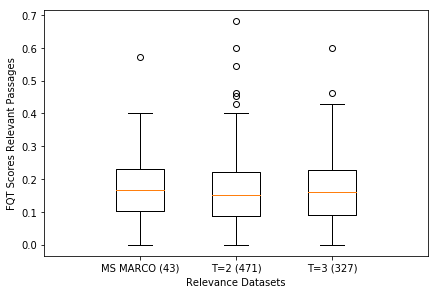

In [78]:
import matplotlib.pyplot as plt
data_a = [ms_marco_fqt_scores]
data_b = [t2_fqt_scores]
data_c = [t3_fqt_scores]

ticks = ['MS MARCO (43)', 'T=2 (471)', 'T=3 (327)']

plt.figure()

bp1 = plt.boxplot(data_a,positions=[0],widths=1)
bp2 = plt.boxplot(data_b,positions=[2],widths=1)
bp3 = plt.boxplot(data_c,positions=[4],widths=1)
plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
#plt.yticks(range(0,1,0.1))
plt.tight_layout()
plt.xlabel("Relevance Datasets")
plt.ylabel("FQT Scores Relevant Passages")
plt.show()

## Compute Average MRR per ranges of FQT

In [16]:
N = 10

In [17]:
def compute_group(fqt):
    for index, (low,high) in enumerate(intervals):
        if (fqt >= low) & (fqt < high):
            return index

In [ ]:
intervals = [(0.0,0.1), (0.1,0.15), (0.15,0.2), (0.2, 0.25), (0.25,1.0)]
bm25_groups = [[],[],[],[],[]]
bert_groups = [[],[],[],[],[]]
for query_id in query_ids:
    bm25_fqt = bm25_fqt_dict[query_id]
    bert_fqt = bert_fqt_dict[query_id]
    bm25_groups[compute_group(bm25_fqt)].append(query_id)
    bert_groups[compute_group(bert_fqt)].append(query_id)

In [19]:
bm25_group_counts = [len(group) for group in bm25_groups]
bert_group_counts = [len(group) for group in bert_groups]

In [20]:
bm25_group_counts

[6, 12, 14, 6, 5]

In [21]:
bert_group_counts

[9, 13, 15, 3, 3]

### Compute BM25 group mrrs for threshold 2

In [22]:
# Irrelevant < 2; relevant >= 2
binary_threshold = 2

model = "bm25"

model_df = models_dict[model].copy()

# Get new relevance dataset
new_qrels_df = new_qrels_dict["threshold=%s"%(binary_threshold)].copy()

og_mrr_per_group = []
new_mrr_per_group = []

for bm25_group in bm25_groups:
    query_ids = bm25_group
    og_qrels_subset_df = og_qrels_df[og_qrels_df['query_id'].isin(query_ids)].copy()
    model_subset_df = model_df[model_df['query_id'].isin(query_ids)].copy()
    
    og_mrr = 0.0
    new_mrr = 0.0
    
    for query_id in query_ids:
        # Get query specific ranking and relevance datasets
        query_subset = model_subset_df[model_subset_df['query_id'] == query_id].copy()
        og_qrels_query_subset = og_qrels_subset_df[og_qrels_subset_df['query_id'] == query_id]
        new_qrels_query_subset = new_qrels_df[new_qrels_df['query_id'] == query_id]
    
        top_n_ranking = get_top_n_ranking(query_subset,'%s_rank'%(model),N)
    
        og_relevant_passages = get_passage_ids(og_qrels_query_subset)
        new_relevant_passages = get_passage_ids(new_qrels_query_subset)
    
        og_mrr += compute_mrr(og_relevant_passages,top_n_ranking,model,N)
        new_mrr += compute_mrr(new_relevant_passages,top_n_ranking,model,N)
    
    og_mrr_per_group.append(round((og_mrr/len(query_ids)),2))
    new_mrr_per_group.append(round((new_mrr/len(query_ids)),2))

In [23]:
og_mrr_per_group

[0.16, 0.66, 0.48, 0.43, 0.3]

In [24]:
new_mrr_per_group

[0.92, 0.96, 1.0, 1.0, 1.0]

### Compute BERT group mrrs for threshold 2

In [25]:
# Irrelevant < 2; relevant >= 2
binary_threshold = 2

model = "bert"

model_df = models_dict[model].copy()

# Get new relevance dataset
new_qrels_df = new_qrels_dict["threshold=%s"%(binary_threshold)].copy()

og_mrr_per_group = []
new_mrr_per_group = []

for bert_group in bert_groups:
    query_ids = bert_group
    og_qrels_subset_df = og_qrels_df[og_qrels_df['query_id'].isin(query_ids)].copy()
    model_subset_df = model_df[model_df['query_id'].isin(query_ids)].copy()
    
    og_mrr = 0.0
    new_mrr = 0.0
    
    for query_id in query_ids:
        # Get query specific ranking and relevance datasets
        query_subset = model_subset_df[model_subset_df['query_id'] == query_id].copy()
        og_qrels_query_subset = og_qrels_subset_df[og_qrels_subset_df['query_id'] == query_id]
        new_qrels_query_subset = new_qrels_df[new_qrels_df['query_id'] == query_id]
    
        top_n_ranking = get_top_n_ranking(query_subset,'%s_rank'%(model),N)
    
        og_relevant_passages = get_passage_ids(og_qrels_query_subset)
        new_relevant_passages = get_passage_ids(new_qrels_query_subset)
    
        og_mrr += compute_mrr(og_relevant_passages,top_n_ranking,model,N)
        new_mrr += compute_mrr(new_relevant_passages,top_n_ranking,model,N)
    
    og_mrr_per_group.append(round((og_mrr/len(query_ids)),2))
    new_mrr_per_group.append(round((new_mrr/len(query_ids)),2))

In [26]:
og_mrr_per_group

[0.65, 0.65, 0.78, 0.49, 0.67]

In [27]:
new_mrr_per_group

[0.94, 0.85, 1.0, 0.57, 1.0]

### Compute BM25 group mrrs for threshold 3

In [28]:
# Irrelevant < 3; relevant >= 3
binary_threshold = 3

model = "bm25"

model_df = models_dict[model].copy()

# Get new relevance dataset
new_qrels_df = new_qrels_dict["threshold=%s"%(binary_threshold)].copy()

og_mrr_per_group = []
new_mrr_per_group = []

for bm25_group in bm25_groups:
    query_ids = bm25_group
    og_qrels_subset_df = og_qrels_df[og_qrels_df['query_id'].isin(query_ids)].copy()
    model_subset_df = model_df[model_df['query_id'].isin(query_ids)].copy()
    
    og_mrr = 0.0
    new_mrr = 0.0
    
    for query_id in query_ids:
        # Get query specific ranking and relevance datasets
        query_subset = model_subset_df[model_subset_df['query_id'] == query_id].copy()
        og_qrels_query_subset = og_qrels_subset_df[og_qrels_subset_df['query_id'] == query_id]
        new_qrels_query_subset = new_qrels_df[new_qrels_df['query_id'] == query_id]
    
        top_n_ranking = get_top_n_ranking(query_subset,'%s_rank'%(model),N)
    
        og_relevant_passages = get_passage_ids(og_qrels_query_subset)
        new_relevant_passages = get_passage_ids(new_qrels_query_subset)
    
        og_mrr += compute_mrr(og_relevant_passages,top_n_ranking,model,N)
        new_mrr += compute_mrr(new_relevant_passages,top_n_ranking,model,N)
    
    og_mrr_per_group.append(round((og_mrr/len(query_ids)),2))
    new_mrr_per_group.append(round((new_mrr/len(query_ids)),2))

In [29]:
og_mrr_per_group

[0.16, 0.66, 0.48, 0.43, 0.3]

In [30]:
new_mrr_per_group

[0.75, 0.96, 0.89, 1.0, 0.9]

### Compute BERT group mrrs for threshold 3

In [31]:
# Irrelevant < 3; relevant >= 3
binary_threshold = 3

model = "bert"

model_df = models_dict[model].copy()

# Get new relevance dataset
new_qrels_df = new_qrels_dict["threshold=%s"%(binary_threshold)].copy()

og_mrr_per_group = []
new_mrr_per_group = []

for bert_group in bert_groups:
    query_ids = bert_group
    og_qrels_subset_df = og_qrels_df[og_qrels_df['query_id'].isin(query_ids)].copy()
    model_subset_df = model_df[model_df['query_id'].isin(query_ids)].copy()
    
    og_mrr = 0.0
    new_mrr = 0.0
    
    for query_id in query_ids:
        # Get query specific ranking and relevance datasets
        query_subset = model_subset_df[model_subset_df['query_id'] == query_id].copy()
        og_qrels_query_subset = og_qrels_subset_df[og_qrels_subset_df['query_id'] == query_id]
        new_qrels_query_subset = new_qrels_df[new_qrels_df['query_id'] == query_id]
    
        top_n_ranking = get_top_n_ranking(query_subset,'%s_rank'%(model),N)
    
        og_relevant_passages = get_passage_ids(og_qrels_query_subset)
        new_relevant_passages = get_passage_ids(new_qrels_query_subset)
    
        og_mrr += compute_mrr(og_relevant_passages,top_n_ranking,model,N)
        new_mrr += compute_mrr(new_relevant_passages,top_n_ranking,model,N)
    
    og_mrr_per_group.append(round((og_mrr/len(query_ids)),2))
    new_mrr_per_group.append(round((new_mrr/len(query_ids)),2))

In [32]:
og_mrr_per_group

[0.65, 0.65, 0.78, 0.49, 0.67]

In [33]:
new_mrr_per_group

[0.94, 0.83, 0.97, 0.57, 0.83]